In [ ]:
!pip install wandb

In [6]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [7]:
!kaggle datasets download -d jangedoo/utkface-new
!unzip -qq utkface-new.zip

 98% 324M/331M [00:03<00:00, 70.0MB/s]
100% 331M/331M [00:03<00:00, 94.5MB/s]


In [2]:
import wandb
import torch, torchvision, cv2, os
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [ ]:
wandb.init(project="AgeEstimating-TransferLearning-by-Torch")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.resnet50(pretrained=True)

## Transfer Learning

In [17]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 1)

This freezes layers 1-6 in the total 10 layers of Resnet50

In [18]:
ct = 0
for child in model.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False

In [19]:
model = model.to(device)

In [20]:
config = wandb.config
config.learning_rate = 0.01
config.batch_size = 32
config.epochs = 15

### Dataset

In [8]:
images = []
ages = []

for image_name in os.listdir('crop_part1')[0:9000]:
    part = image_name.split('_')
    ages.append(int(part[0]))

    image = cv2.imread(f'crop_part1/{image_name}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

In [9]:
images = pd.Series(images, name= 'Images')
ages = pd.Series(ages, name= 'Ages')

df = pd.concat([images, ages], axis= 1)
df.head()

,Images,Ages
0,"[[[253, 236, 216], [253, 237, 214], [255, 237,...",1
1,"[[[47, 28, 13], [49, 30, 15], [48, 30, 16], [4...",68
2,"[[[245, 245, 245], [246, 246, 246], [247, 245,...",52
3,"[[[51, 45, 49], [45, 39, 43], [35, 30, 34], [2...",27
4,"[[[167, 135, 114], [166, 134, 113], [169, 137,...",4


In [10]:
under4 = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4.append(df.iloc[i])

under4 = pd.DataFrame(under4)
under4 = under4.sample(frac= 0.3)

up4 = df[df['Ages'] > 4]

df = pd.concat([under4, up4])

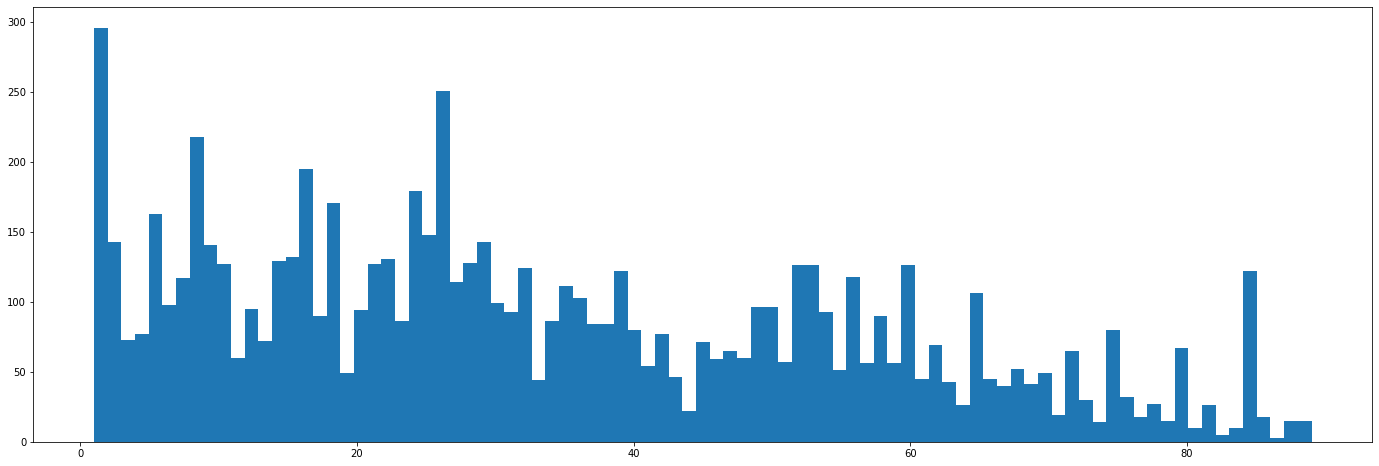

In [11]:
df = df[df['Ages'] < 90]
plt.figure(figsize=(24, 8))
plt.hist(df['Ages'], bins= 89)
plt.show()

In [13]:
width = height = 224
X = []
Y = []

for i in range(len(df)):
    df['Images'].iloc[i] = cv2.resize(df['Images'].iloc[i], (width, height))

    X.append(df['Images'].iloc[i])
    Y.append(df['Ages'].iloc[i])

X = np.array(X)
Y = np.array(Y)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [14]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)

In [15]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform=None):
        self.data = X
        self.target = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y
    
    def __len__(self):
        return len(self.data)

In [26]:
data_transform = transforms.Compose([
                                     transforms.ToPILImage(),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.Resize((70, 70)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                     ])


dataset = MyDataset(X_train, Y_train, data_transform)
train_data_loader = torch.utils.data.DataLoader(dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)

### Compile

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
loss_function = torch.nn.MSELoss()

## Train

In [ ]:
model.train()

In [38]:
wandb.watch(model)

for epoch in range(config.epochs):
    train_loss = 0.0
    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # 1- forwarding
        preds = model(images)
        # 2- backwarding 
        loss = loss_function(preds, labels.float())
        loss.backward()
        # 3- Update
        optimizer.step()

        train_loss += loss
    
    total_loss = train_loss / len(train_data_loader)

    if epoch % 2 == 0:
        wandb.log({"loss": total_loss})

    print(f"Epoch: {epoch}, Loss: {total_loss}")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, Loss: 554.1524047851562


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1, Loss: 544.5789184570312
Epoch: 2, Loss: 541.218017578125
Epoch: 3, Loss: 541.533203125
Epoch: 4, Loss: 539.135009765625
Epoch: 5, Loss: 536.3722534179688
Epoch: 6, Loss: 538.1422119140625
Epoch: 7, Loss: 536.1314086914062
Epoch: 8, Loss: 536.3677368164062
Epoch: 9, Loss: 539.5089721679688
Epoch: 10, Loss: 534.5001220703125
Epoch: 11, Loss: 536.3848876953125
Epoch: 12, Loss: 534.1768798828125
Epoch: 13, Loss: 535.8567504882812
Epoch: 14, Loss: 536.9237060546875


In [39]:
torch.save(model.state_dict(), "age-estimating-resnet50-torch.pth")